In [1]:
# If you're in Jupyter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load the data (updated for the warning)
df = pd.read_csv("./output/mf_m4.txt", sep=r"\s+", comment="#", header=None)

# Check the shape just to be sure
print(df.shape)  # should be (n_samples, at least 4): omega_m, sigma8, prior, post

# You’ll need to check how many columns you have
# Assuming the order is: omega_m, sigma8_input, prior, posterior
df.columns = ["omega_m", "sigma8", "prior", "posterior"]

(64000, 4)


<>:7: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_676150/1080225538.py:7: SyntaxWarning: invalid escape sequence '\O'
  axes[0].set_title("Trace Plot: $\Omega_m$")
/tmp/ipykernel_676150/1080225538.py:13: SyntaxWarning: invalid escape sequence '\s'
  axes[1].set_title("Trace Plot: $\sigma_8$")


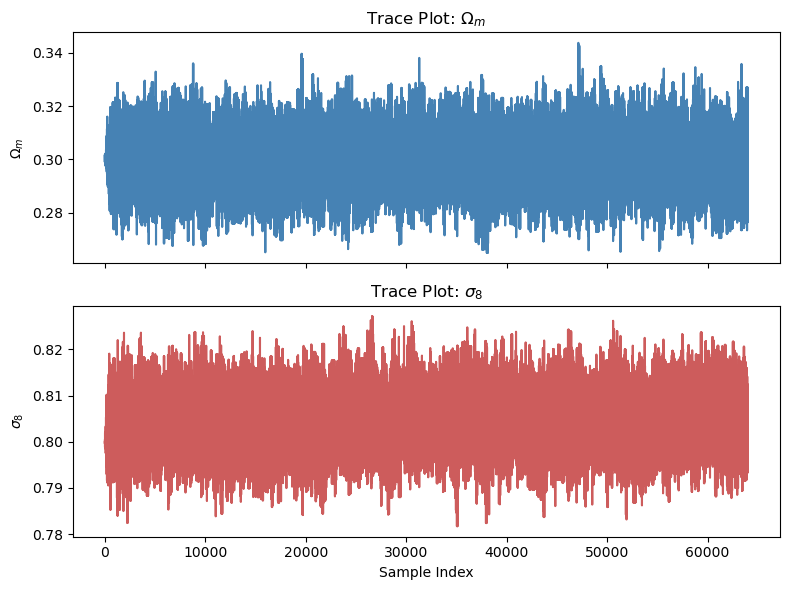

In [3]:
# Create figure with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Trace plot for omega_m
axes[0].plot(df["omega_m"], color='steelblue')
axes[0].set_ylabel(r'$\Omega_m$')
axes[0].set_title("Trace Plot: $\Omega_m$")

# Trace plot for sigma8
axes[1].plot(df["sigma8"], color='indianred')
axes[1].set_ylabel(r'$\sigma_8$')
axes[1].set_xlabel("Sample Index")
axes[1].set_title("Trace Plot: $\sigma_8$")

plt.tight_layout()
plt.show()


In [4]:
from getdist import MCSamples, plots

# --- Step 1: Compute S8 ---
df["S8"] = df["sigma8"] * (df["omega_m"] / 0.3)**0.5

# --- Step 2: Prepare samples array ---
samples = df[["omega_m", "sigma8", "S8"]].values

# --- Step 3: Parameter names and LaTeX labels ---
names = ['omega_m', 'sigma8', 'S8']
labels = [r'\Omega_m', r'\sigma_8', r'S_8']

# --- Step 4: Create MCSamples object ---
mc_samples = MCSamples(samples=samples, names=names, labels=labels)

# --- Step 5: Triangle plot ---
g = plots.getSubplotPlotter()
#g.settings.fine_bins_2D = 100  # or 150, 200 if needed
g.triangle_plot(mc_samples, filled=True)
plt.show()

Removed no burn in


In [5]:
#likelihood text for speeding up the process: replace quad to Gauss-Legendre integration

from numpy.polynomial.legendre import leggauss
from hmf import MassFunction
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

h = 0.7
H0 = h * 100  # km/s/Mpc
zmin = 0.3
zmax = 0.8
area_deg2 = 1000.0
Mmin_h = 1e14 / h  # Msun/h
Mmax_h = 5e14 / h # Msun/h 
sigma8 = 0.8
Om0 = 0.318

def volume_shell(zmin, zmax, Om0, area_deg2):
    """Return h^-3 Mpc^3 so it pairs with h^3 Mpc^-3 number densities."""
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    V = (cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)).to(u.Mpc**3).value
    V /= h**3                            # -> h^-3 Mpc^3
    f_sky = area_deg2 / 41253.0
    return V * f_sky

def number_density_z(z, sigma8, Om0, Mmin_h, Mmax_h):
    mf = MassFunction(
        z=z,
        sigma_8=sigma8,         # fixed fiducial
        cosmo_params={"H0": H0, "Om0": Om0},
        Mmin=np.log10(Mmin_h),
        Mmax=np.log10(Mmax_h),
        dlog10m=0.001,
        hmf_model="Tinker08",
        #n=0.96,
        #mdef="500c"
    )
    
    # Mass grid (Msun/h) and dn/dM units: h^3 Mpc^-3 (Msun/h)^-1
    M = mf.m
    dM = np.gradient(M)
    n_z = np.sum(mf.dndm * dM)   # -> h^3 Mpc^-3
    return n_z

def integrate_fixed(n_z, zmin, zmax, N=12):
    x, w = leggauss(N)
    z_nodes = 0.5*(zmax - zmin)*x + 0.5*(zmax + zmin)
    weights = 0.5*(zmax - zmin)*w
    return np.sum(weights * np.array([n_z(z) for z in z_nodes]))

In [6]:
n_z = lambda z: number_density_z(z, sigma8, Om0, Mmin_h, Mmax_h)
#N_int = integrate_fixed(n_z, zmin, zmax)
for N in [2, 4, 6]:
    val = integrate_fixed(n_z, zmin, zmax, N=N)
    V = volume_shell(zmin, zmax, Om0, area_deg2)
    N_obs = V * val
    print(f"N={N:2d} → {N_obs}")

/global/homes/x/xintang/anaconda3/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


N= 2 → 14604.430439914535
N= 4 → 14598.613227939519
N= 6 → 14598.613599767205


In [7]:
import sys
!{sys.executable} -m pip install -U hmf

In [8]:
import inspect, hmf
from hmf import MassFunction
supports_mdef = "mdef" in inspect.signature(MassFunction).parameters or \
                "mdef_model" in inspect.signature(MassFunction).parameters
print(hmf.__version__, "supports mdef?", supports_mdef)

3.5.1 supports mdef? False


In [16]:
# Constants
h = 0.7
H0 = h * 100
Om0 = 0.318
sigma8 = 0.8
Mmin = 10 ** 13.5  # Msun
Mmax = 1e15  # Msun
Mmin_h = Mmin / h
Mmax_h = Mmax / h

# Survey area (deg^2)
area_deg2 = 13000.0

from hmf.halos.mass_definitions import SOCritical  # 500c

#mdef = SOCritical(500)  # 500 wrt critical

mf = MassFunction(
    z=0.3,
    cosmo_params={"H0": H0, "Om0": Om0},
    sigma_8=sigma8,
    Mmin=np.log10(Mmin/h), Mmax=np.log10(Mmax/h),
    hmf_model="Tinker08",
    #mdef=mdef,                 # <-- only works if your version supports it
)
M = mf.m
dM = np.gradient(M)

def volume_shell(zmin, zmax, Om0, area_deg2):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    V = (cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)).to(u.Mpc**3).value
    V /= h**3
    f_sky = area_deg2 / 41253.0
    return V * f_sky

# for mass bin 5e12 to 2e15 and redshift bin 0.03 to 1.32


nM = 10
M_edges_logh = np.linspace(np.log10(Mmin/h), np.log10(Mmax/h), nM+1)
M_centres_logh = 0.5*(M_edges_logh[:-1] + M_edges_logh[1:])

# Mass scaling: lowest mass -> 0.1, highest -> 0.9
mass_scale = np.linspace(0.01, 1, nM)

# New redshift binning
z_edges = np.linspace(0.0, 1.0, 11)  # 10 bins from 0 to 1
z_centres = 0.5 * (z_edges[:-1] + z_edges[1:])
Nz = len(z_edges) - 1

def redshift_scale(z):
    """Return scaling factor depending on z using (1+z)^-4 dimming."""
    return (1.0 / (1.0 + z)**4)

N_counts = []

for iz, (zmin, zmax) in enumerate(zip(z_edges[:-1], z_edges[1:])):
    z_mid = 0.5*(zmin+zmax)
    V = volume_shell(zmin, zmax, Om0, area_deg2)

    N_counts_mass = 0.0  # Reset for each redshift bin
    for im, (logMmin, logMmax) in enumerate(zip(M_edges_logh[:-1], M_edges_logh[1:])):
        mf.update(Mmin=logMmin, Mmax=logMmax, z=z_mid)
        dM = np.gradient(mf.m)
        n_z = np.sum(mf.dndm * dM)  # h^3 Mpc^-3
        N_counts_mass += n_z * V * mass_scale[im]  # Adjusted for bin width

    N_counts.append(N_counts_mass * redshift_scale(z_mid))  # Adjusted for redshift scaling


# Plot
plt.figure(figsize=(7,5))
plt.bar(
    z_edges[:-1],        # left edges
    N_counts,                 # heights
    width=np.diff(z_edges),  # bin widths in log space
    align="edge", edgecolor="k", alpha=0.7
)

#plt.figure(figsize=(6,4))
#plt.plot(z_centres, N_counts, marker='o')
plt.xlabel("Redshift z")
plt.ylabel("Number of clusters per bin")
plt.title(fr"{area_deg2} deg² survey, $M\in[1\times10^{{13}},\,1\times10^{{14}}]\,M_\odot$")
plt.grid(True, ls=":")
plt.show()

In [10]:
N_counts = []

for zmin, zmax in zip(z_edges[:-1], z_edges[1:]):
    z_mid = 0.5*(zmin+zmax)
    V = volume_shell(zmin, zmax, Om0, area_deg2)

    N_counts_mass = 0.0
    for logMmin, logMmax in zip(M_edges_logh[:-1], M_edges_logh[1:]):
        # fix mass bin + redshift on HMF
        mf.update(Mmin=logMmin, Mmax=logMmax, z=z_mid)

        # per-bin midpoint mass in Msun/h for scaling
        Mmid_h = 10**(0.5*(logMmin + logMmax))       # Msun/h
        M_ref_h = 1e15 / h                            # Msun/h
        sM = min(1.0, (Mmid_h / M_ref_h)**(4.0/3.0))  # mass scaling

        # integrate dn/dM over this mass bin
        Mgrid = mf.m  # Msun/h
        if Mgrid.size < 2:
            # rare ultra-narrow fallback: rectangle rule with bin width in Msun/h
            dM_bin = (10**logMmax - 10**logMmin)
            n_z = mf.dndm[0] * dM_bin
        else:
            dM = np.gradient(Mgrid)
            n_z = np.einsum('i,i->', mf.dndm, dM, dtype=float)  # h^3 Mpc^-3

        N_counts_mass += n_z * V * sM

    N_counts.append(N_counts_mass * redshift_scale(z_mid) * 900/5000)

# --- plot
plt.figure(figsize=(7,5))
plt.bar(
    z_edges[:-1],
    N_counts,
    width=np.diff(z_edges),  # linear Δz width
    align="edge", edgecolor="k", alpha=0.7
)
plt.xlabel("Redshift z")
plt.ylabel("Number of clusters per bin")
plt.title(fr"{area_deg2:.0f} deg$^2$ survey, $M\in[10^{{13.5}},\,10^{{15}}]\,M_\odot$, $s_z=(1+z)^{{-4}}$, $s_M\propto M^{{4/3}}$")
plt.grid(True, ls=":")
plt.show()

In [11]:
def mass_scale(M):
    # Normalise so that S_M(1e15) = 1
    return (M / 1e15)**(4/3)

# Binning
nM = 10
M_edges = np.logspace(13.5, 15.0, nM+1)   # Msun
z_edges = np.linspace(0.0, 1.0, 11)       # 10 bins
Nz, nM = len(z_edges)-1, len(M_edges)-1

# 2D counts
N_counts = np.zeros((nM, Nz))

for iz, (zmin, zmax) in enumerate(zip(z_edges[:-1], z_edges[1:])):
    z_mid = 0.5*(zmin+zmax)
    Vz = volume_shell(zmin, zmax, Om0, area_deg2)
    for im, (Mlo, Mhi) in enumerate(zip(M_edges[:-1], M_edges[1:])):
        mf.update(Mmin=np.log10(Mlo/h), Mmax=np.log10(Mhi/h), z=z_mid)
        dM = np.gradient(mf.m)
        n_z = np.sum(mf.dndm * dM)   # [h^3/Mpc^3]
        # Apply scaling
        N_counts[im, iz] = n_z * Vz * redshift_scale(z_mid) * mass_scale(0.5*(Mlo+Mhi))

# Plot
plt.figure(figsize=(7.5, 5.5))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), N_counts, shading="auto")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.xlabel("Redshift z")
plt.title(r"Scaled counts per $(z,M)$ bin: $S_z=(1+z)^{-4},\,S_M\propto M^{4/3}$")
plt.colorbar(pcm, label="Counts")
plt.tight_layout()
plt.show()

In [12]:
from astropy.cosmology import FlatwCDM

# ---------- cosmologies ----------
#cosmo_conc = FlatwCDM(H0=H0, Om0=Om0, w0=-1.0)
cosmo_desi = FlatwCDM(H0=H0, Om0=Om0, w0=-0.9, Ob0=0.049, Tcmb0=2.7255*u.K)
mf_desi = MassFunction(cosmo_model=cosmo_desi, hmf_model="Tinker08")

# --- take your existing ΛCDM grid as "concordance"
N_conc = np.array(N_counts, copy=True)   # shape (nM, Nz)

def volume_shell_cosmo(cosmo, zmin, zmax, area_deg2):
    V = (cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)).to(u.Mpc**3).value
    f_sky = area_deg2 / 41253.0
    return V * f_sky / h**3

# 2D counts
N_desi = np.zeros((nM, Nz))

for iz, (zmin, zmax) in enumerate(zip(z_edges[:-1], z_edges[1:])):
    z_mid = 0.5*(zmin+zmax)
    Vz = volume_shell_cosmo(cosmo_desi, zmin, zmax, area_deg2)
    for im, (Mlo, Mhi) in enumerate(zip(M_edges[:-1], M_edges[1:])):
        mf_desi.update(Mmin=np.log10(Mlo/h), Mmax=np.log10(Mhi/h), z=z_mid)
        dM = np.gradient(mf.m)
        n_z = np.sum(mf.dndm * dM)   # [h^3/Mpc^3]
        # Apply scaling
        N_desi[im, iz] = n_z * Vz * redshift_scale(z_mid) * mass_scale(0.5*(Mlo+Mhi))

# --- apply your global 900/5000 scaling to BOTH before comparing
k = 900.0/5000.0
N_conc_scaled = N_conc * k
N_desi_scaled = N_desi * k

S = np.sqrt((N_desi_scaled - N_conc_scaled)**2) / np.sqrt(N_conc_scaled)

# --- plot S grid (x=z, y=log10 M)
plt.figure(figsize=(8, 5.8))
pcm = plt.pcolormesh(z_edges, np.log10(M_edges), S, shading="auto")
plt.xlabel("Redshift z")
plt.ylabel(r"$\log_{10}(M/M_\odot)$")
plt.title(r"DESI ($w=-0.9$) vs ΛCDM ($w=-1$): log(|$N_{\rm DESI}-N_{\rm conc}|/\sqrt{N_{\rm conc}}$)")
cbar = plt.colorbar(pcm)
#cbar.set_label("σ (Poisson-like)")
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from hmf import MassFunction

# -------- constants / setup --------
h = 0.7
H0 = h * 100
Om0 = 0.318
sigma8 = 0.8

Mmin = 1e13   # Msun (no h)
Mmax = 2e15   # Msun (no h)

area_deg2 = 13000.0
z_edges = np.linspace(0.03, 1.32, 14)   # 13 redshift bins
Nz = len(z_edges) - 1

# MassFunction (build once to lock code-paths; we’ll update per-bin)
mf = MassFunction(
    z=0.0, sigma_8=sigma8,
    cosmo_params={"H0": H0, "Om0": Om0},
    Mmin=np.log10(Mmin / h),
    Mmax=np.log10(Mmax / h),
    # dlog10m=0.1,  # optional
    hmf_model="Tinker08",
    # extrapolate_with_eh=True,  # uncomment to silence the hmf warning
)

def volume_shell(zmin, zmax, Om0, area_deg2):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    V = (cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)).to(u.Mpc**3).value
    V /= h**3
    return V * (area_deg2 / 41253.0)

# -------- binning in mass (10 log-spaced bins in log10(M/h)) --------
nM = 10
M_edges_logh = np.linspace(np.log10(Mmin / h), np.log10(Mmax / h), nM + 1)
M_centres_logh = 0.5 * (M_edges_logh[:-1] + M_edges_logh[1:])  # for plotting

# Linear scaling factors: 0.1 (lowest mass) → 0.9 (highest mass)
scale = np.linspace(0.1, 0.9, nM)

# Output: counts per (z bin, mass bin) AFTER scaling
N_counts = np.zeros((Nz, nM), dtype=float)

# If mf exposes its baseline dlog step, keep it; else pick a default
dlog10m_base = getattr(mf, "dlog10m", 0.1)

for iz, (zmin, zmax) in enumerate(zip(z_edges[:-1], z_edges[1:])):
    # Use midpoint in z (switch to Gauss–Legendre if you want more accuracy)
    z_mid = 0.5 * (zmin + zmax)
    Vz = volume_shell(zmin, zmax, Om0, area_deg2)

    for im, (logMmin, logMmax) in enumerate(zip(M_edges_logh[:-1], M_edges_logh[1:])):
        # Ensure enough mass points inside this (possibly narrow) bin
        dlog = logMmax - logMmin
        local_dlog = min(dlog10m_base, dlog / 3.0) if dlog > 0 else dlog10m_base

        # Lock mass bin and resolution
        mf.update(Mmin=logMmin, Mmax=logMmax, dlog10m=local_dlog)

        # Fixed mass grid for this bin
        M_h = mf.m                 # Msun/h
        if M_h.size < 2:
            # ultra-narrow fallback (should be rare with the logic above)
            # rectangle rule using tiny width around midpoint
            Mmid_h = 10**(0.5 * (logMmin + logMmax))
            dM_bin = (10**logMmax - 10**logMmin)  # (Msun/h)
            mf.update(z=z_mid, Mmin=np.log10(Mmid_h), Mmax=np.log10(Mmid_h * (1 + 1e-6)))
            n_z = mf.dndm[0] * dM_bin            # h^3 Mpc^-3
        else:
            dM = np.gradient(M_h)
            # Only z varies now
            mf.update(z=z_mid)
            # dn/dM [h^3 Mpc^-3 (Msun/h)^-1] * dM [(Msun/h)] → h^3 Mpc^-3
            n_z = np.einsum("i,i->", mf.dndm, dM, dtype=float)

        # Expected count in this (z, M) bin
        N = n_z * Vz

        # Apply the linear scaling for this mass bin
        N_counts[iz, im] = N * scale[im]

# -------- plotting --------
# Replace the 2D heatmap with a 1D count–redshift plot (summed over 10 mass bins)
z_centres = 0.5 * (z_edges[:-1] + z_edges[1:])
N_counts_z = N_counts.sum(axis=1)  # sum over mass bins -> shape (Nz,)

plt.figure(figsize=(7,5))
plt.bar(
    z_edges[:-1],            # left edges of z bins
    N_counts_z,              # total counts per redshift bin (after scaling)
    width=np.diff(z_edges),
    align="edge", edgecolor="k", alpha=0.7
)
plt.xlabel("Redshift z")
plt.ylabel("Scaled number of clusters per z-bin")
plt.title(f"{area_deg2:.0f} deg², {nM} mass bins scaled 0.1→0.9 (summed over mass)")
plt.grid(True, ls=":")
plt.show()


/global/homes/x/xintang/anaconda3/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


In [14]:
from scipy.integrate import quad
# Bins in z for N(M)
# define bins in log10(M/h)
M_edges_logh = np.linspace(np.log10(5e12/h), np.log10(1e15/h), 20)
# centres (for plotting) in linear Msun
M_centres_logh = 0.5 * (M_edges_logh[:-1] + M_edges_logh[1:])

N_counts = []
zmin, zmax = 0.03, 1.0
V = volume_shell(zmin, zmax, Om0, area_deg2)

def integrate_fixed(n_z, zmin, zmax, N=8):
    x, w = leggauss(N)
    z_nodes = 0.5*(zmax - zmin)*x + 0.5*(zmax + zmin)
    weights = 0.5*(zmax - zmin)*w
    return float(np.sum(weights * np.array([n_z(z) for z in z_nodes])))

for logMmin, logMmax in zip(M_edges_logh[:-1], M_edges_logh[1:]):
    # tell hmf to use these log10(M/h) bounds
    mf.update(Mmin=logMmin, Mmax=logMmax)
    dM = np.gradient(mf.m)  # mf.m is linear Msun/h

    def n_of_z(z):
        mf.update(z=z)   # only z changes
        return np.einsum('i,i->', mf.dndm, dM, dtype=float)

    N_int = integrate_fixed(n_of_z, zmin, zmax, N=8)   # h^3 Mpc^-3
    N_counts.append(N_int * V) 

# Plot histogram of counts vs log10(M/h)
plt.figure(figsize=(7,5))
plt.bar(
    M_edges_logh[:-1],        # left edges
    N_counts,                 # heights
    width=np.diff(M_edges_logh),  # bin widths in log space
    align="edge", edgecolor="k", alpha=0.7
)

plt.xlabel(r"$\log_{10}(M/h^{-1}M_\odot)$")
plt.ylabel("Number of clusters per bin")
plt.title(f"{area_deg2} deg² survey, {zmin:.2f} < z < {zmax:.2f}")
plt.grid(True, ls=":")
plt.show()

N_counts = []

for logMmin, logMmax, i in zip(M_edges_logh[:-1], M_edges_logh[1:], range(len(M_edges_logh)-1)):
    # tell hmf to use these log10(M/h) bounds
    mf.update(Mmin=logMmin, Mmax=logMmax)
    dM = np.gradient(mf.m)  # mf.m is linear Msun/h

    def n_of_z(z):
        mf.update(z=z)   # only z changes
        return np.einsum('i,i->', mf.dndm, dM, dtype=float)

    N_int = integrate_fixed(n_of_z, zmin, zmax, N=8)   # h^3 Mpc^-3
    N_counts.append(N_int * V * (i+1) * (0.9-0.1)/20) 

# Plot histogram of counts vs log10(M/h)
plt.figure(figsize=(7,5))
plt.bar(
    M_edges_logh[:-1],        # left edges
    N_counts,                 # heights
    width=np.diff(M_edges_logh),  # bin widths in log space
    align="edge", edgecolor="k", alpha=0.7
)

plt.xlabel(r"$\log_{10}(M/h^{-1}M_\odot)$")
plt.ylabel("Number of clusters per bin")
plt.title(f"{area_deg2} deg² survey, {zmin:.2f} < z < {zmax:.2f}")
plt.grid(True, ls=":")
plt.show()

In [15]:
from astropy.cosmology import Flatw0waCDM
from numpy.polynomial.legendre import leggauss

# --- constants ---
h = 0.7
H0 = 100*h
Om0 = 0.318
sigma8 = 0.8
area_deg2 = 13000.0
f_sky = area_deg2 / 41253.0

# mass range (Msun/h) for HMF
Mmin_h = 1e14 / h
Mmax_h = 2e15 / h

# redshift binning: 0.03 -> 1.32
z_lo, z_hi = 0.03, 1.32
Nz_bins = 13                      # ~Δz ≈ 0.1 across 1.29 range
z_edges = np.linspace(z_lo, z_hi, Nz_bins+1)
z_centres = 0.5*(z_edges[1:] + z_edges[:-1])

# GL order for within-bin z integration
Nz_GL = 6

def counts_vs_z_for_w0wa(w0, wa):
    """
    Counts per z-bin for Flatw0waCDM(w0, wa), integrating n(z)*dV/dz.
    """
    # Use same cosmology for HMF + geometry; include Ob0/Tcmb0 to keep backends happy
    cosmo = Flatw0waCDM(H0=H0, Om0=Om0, w0=w0, wa=wa, Ob0=0.049, Tcmb0=2.7255*u.K)

    # One MassFunction reused across z-nodes
    mf = MassFunction(
    z=0.0, sigma_8=sigma8,
    cosmo_model=Flatw0waCDM(H0=H0, Om0=Om0, w0=w0, wa=wa, Ob0=0.049, Tcmb0=2.7255*u.K),
    Mmin=np.log10(Mmin_h), Mmax=np.log10(Mmax_h),
    dlog10m=0.1, hmf_model="Tinker08",
    transfer_model="EH",   # <-- bypass CAMB
    #extrapolate_with_eh=True
    )
    M = mf.m
    dM = np.gradient(M)

    counts = []
    for zmin, zmax in zip(z_edges[:-1], z_edges[1:]):
        x, wts = leggauss(Nz_GL)
        z_nodes   = 0.5*(zmax - zmin)*x + 0.5*(zmax + zmin)
        z_weights = 0.5*(zmax - zmin)*wts

        N_bin = 0.0
        for zz, ww in zip(z_nodes, z_weights):
            mf.update(z=float(zz))
            n_zz = np.einsum('i,i->', mf.dndm, dM, dtype=float)     # h^3 Mpc^-3

            dVdz_dOmega = cosmo.differential_comoving_volume(zz).to(u.Mpc**3/u.sr).value
            dVdz = dVdz_dOmega * (4*np.pi) * f_sky                   # Mpc^3
            dVdz *= 1.0/(h**3)                                       # -> h^-3 Mpc^3

            N_bin += ww * (n_zz * dVdz)
        counts.append(N_bin)

    return np.array(counts)

# ----- choose (w0, wa) models to compare -----
models = [
    (-1.0,  0.0),  # baseline ΛCDM
    (-0.88,  -0.3),  
    (-0.85,  -0.8),
    (-0.66,  -1.5),
]

# compute
counts = {(w0,wa): counts_vs_z_for_w0wa(w0,wa) for (w0,wa) in models}
baseline = counts[(-1.0, 0.0)]

# ----- Plot 1: absolute counts (optional for context) -----
plt.figure(figsize=(7,5))
for (w0,wa), arr in counts.items():
    lbl = rf'$w_0={w0:.1f},\, w_a={wa:.1f}$'
    plt.plot(z_centres, arr, marker='o', label=lbl)
plt.xlabel(r'$z$')
plt.ylabel('Number per $\Delta z$ bin')
plt.title(rf'Counts vs $z$, $M\in[10^{{14}},\,2\times10^{{15}}]\,M_\odot$, area={area_deg2:.0f} deg$^2$')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# ----- Plot 2: difference vs baseline (w0=-1, wa=0) -----
plt.figure(figsize=(7,5))
for (w0,wa), arr in counts.items():
    if (w0,wa) == (-1.0, 0.0): 
        continue
    diff = arr - baseline
    lbl = rf'$w_0={w0:.1f},\, w_a={wa:.1f}$'
    plt.plot(z_centres, diff, marker='o', label=lbl)
plt.axhline(0, ls='--', lw=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$\Delta N(z)$ vs baseline')
plt.title(r'Difference vs $(w_0,w_a)=(-1,0)$')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

<>:82: SyntaxWarning: invalid escape sequence '\D'
<>:82: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_676150/478538547.py:82: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Number per $\Delta z$ bin')
